In [ ]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
%matplotlib inline

from cvxopt import matrix, solvers
from tqdm.auto import tqdm

In [ ]:
reward_func1 = np.array(
    [
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,-10,-10,0,0,0], 
        [0,0,0,0,0,-10,-10,0,0,0],
        [0,-10,-10,0,0,0,0,0,0,0],
        [0,-10,-10,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,-10,-10,0,0,0,0,0,0],
        [0,0,-10,-10,0,0,0,0,0,1],
    ]
)

In [ ]:
## Define the gridworld MDP class

class Gridworld(object):
    """
    Gridworld MDP.
    """
    
    def __init__(self, grid_size, wind, discount):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)
    
    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)
        

        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - 0.75 * self.wind

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind / 4

        
        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if i in [0, self.grid_size-1, self.grid_size*10, self.grid_size**2-1]:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size: 
                # we have the regular success chance of staying here
                # plus an extra chance of blowing onto the *other* off-grid square
                return 1 - 0.5 * self.wind
            else:
                # We can blow off the grid in either direction only by wind.
                return 0.5 * self.wind
        else:
            # Not a corner. Is it an edge?
            if 0 < xi < self.grid_size-1 and 0 < yi < self.grid_size-1:
                return 0
            
            else:#it is an edge
                # we Can only move off the edge in one direction.
                # Did we intend to move off the grid?
                if min(xi+xj, yi+yj) < 0 or max(xi+xj, yi+yj) >= self.grid_size:
                    #we have the regular success chance of staying here.
                    return 1 - 0.75 * self.wind
                else:
                    # We can blow off the grid only by wind.
                    return self.wind / 4

    def lp_reward(self, state_int, rw_function=1):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """
        if rw_function == 1:
            postive_reward = 1
            negative_reward = -10
            negative_set = {14, 15, 24, 25, 28, 29, 38, 39, 52, 53, 62, 63}
        if rw_function == 2:
            postive_reward = 10
            negative_reward = -100
            negative_set = {41, 42, 43, 44, 45, 46, 51, 61, 62, 
                            63, 67, 68, 73, 77, 83, 84, 85, 86, 87}
        
        #look at figure 6,7 to retrurn a reward at the given state. 
        if state_int == 99:
            return postive_reward
        elif state_int in negative_set:
            return negative_reward
        else:
            return 0

In [ ]:
## Function for plotting the matrix values

def plot_matrix(matrix):
    fig, ax = plt.subplots()
    num_rows = len(matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = matrix[i][j]
            ax.text(j+0.5, i+0.5, '{:.1f}'.format(c), va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    plt.show()
    plt.close()

In [ ]:
## Creating the gridworld MDP with the following parameters

grid_size = 10
wind = 0.1
discount = 0.8

# Make the gridworld and associated data.
gw = Gridworld(grid_size, wind, discount)

In [ ]:
def find_policy(n_states, n_actions, transition_probabilities, reward, discount,
                threshold=1e-2, v=None, stochastic=False):
    """
    Find the optimal policy.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (state, action, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    v: Value function (if known). Default None.
    stochastic: Whether the policy should be stochastic. Default True.
    -> Action probabilities for each state or action int for each state
        (depending on stochasticity).
    """

    if v is None:
        v = optimal_value(n_states, n_actions, transition_probabilities, reward,
                          discount, threshold)

    def _policy(s):
        # calculate new v[i]
        new_values = []
        for a in range(n_actions):
            new_values.append(np.dot(transition_probabilities[s][a], 
                                        (reward + discount * v)))
        return np.argmax(new_values)
     
    policy = np.array([_policy(s) for s in range(n_states)])
    return policy

In [ ]:
def calculate_D_and_b(best_policy, discount_factor, max_reward):
    direction_map = {u"\u2191": 0, u"\u2193": 1, u"\u2190": 2, u"\u2192":3}
    transition_probs = list(compute_tps(w))
    expected_probabilities = []
    agent_probabilities = [[], [], []]

    for state in range(100):
        expected_action = direction_map[best_policy[state]]
        agent = 0
        for action in range(4):
            if action == expected_action:
                expected_probabilities.append(transition_probs[action][state])
            else:
                agent_probabilities[agent].append(transition_probs[action][state])
                agent += 1

    expected_probabilities = np.array(expected_probabilities)
    identity_matrix = np.eye(100)
    zero_matrix = np.zeros((100, 100))
    D_matrix = np.concatenate((zero_matrix, zero_matrix, zero_matrix, zero_matrix))
    D_matrix = np.concatenate(
        (D_matrix, np.concatenate((-identity_matrix, -identity_matrix, zero_matrix, zero_matrix)), np.concatenate((identity_matrix, -identity_matrix, identity_matrix, -identity_matrix))), 1
    )
 
    for agent_probability in agent_probabilities:
        temp = np.dot(np.array(agent_probability) - expected_probabilities, np.linalg.inv(identity_matrix - discount_factor*expected_probabilities))
        temp1 = np.concatenate((identity_matrix, zero_matrix, temp), 1)
        temp2 = np.concatenate((zero_matrix, zero_matrix, temp), 1)
        D_matrix = np.concatenate((np.concatenate((temp1, temp2)), D_matrix))

    b_vector_1 = np.array([0.0 for _ in range(800)])
    b_vector_2 = np.array([max_reward for _ in range(200)])
    b_vector = np.concatenate((b_vector_1, b_vector_2), axis=0)
    return matrix(D_matrix), matrix(b_vector)


def calculate_c(lambda_value):
    c_vector_1 = np.array([-1.0 for _ in range(100)])
    c_vector_2 = np.array([lambda_value for _ in range(100)])
    c_vector_3 = np.array([0.0 for _ in range(100)])
    return matrix(np.concatenate((c_vector_1, c_vector_2, c_vector_3), axis=0))


In [ ]:
def plot_and_get_accuracies(lambdas, optimal_policy, gamma, r_max, title):
    I = np.identity(100)
    accs = []
    
    D, b = compute_D_and_b(optimal_policy, gamma, r_max)
    
    for lambda_ in tqdm(lambdas):
        c = compute_c(lambda_)
        rewards = get_lp_rewards(c, D, b)
        agent_policy = get_optimal_policy(w, gamma, rewards, epsilon)
        agent_policy = agent_policy.T.flatten()
        acc = (agent_policy == optimal_policy).mean()
        accs.append(acc)

    plt.plot(lambdas, accs)
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()
    
    return accs


def get_lp_rewards(c, D, b):
    solvers.options["show_progress"] = False
    solution = solvers.lp(c, D, b)
    return np.array(solution["x"][-100:])

In [ ]:
def compute_state_value_snapshots(w, gamma, reward_func, epsilon):
    transition_probabilities_up, transition_probabilities_down, transition_probabilities_left, transition_probabilities_right = compute_tps(w)
    state_values = np.zeros(100)
    change = float('inf')
    rewards = (reward_func.transpose()).flatten()
    iteration = 0
    value_snapshots = []
    
    while change > epsilon:
        change = 0
        previous_state_values = np.copy(state_values)
        for state in range(100):
            up_value = np.sum(transition_probabilities_up[state] * (rewards + gamma*previous_state_values))
            down_value = np.sum(transition_probabilities_down[state] * (rewards + gamma*previous_state_values))
            left_value = np.sum(transition_probabilities_left[state] * (rewards + gamma*previous_state_values))
            right_value = np.sum(transition_probabilities_right[state] * (rewards + gamma*previous_state_values))
            state_values[state] = max(up_value, down_value, right_value, left_value)
            change = max(change, abs(previous_state_values[state]-state_values[state]))
        iteration += 1
        value_snapshots.append(np.copy(state_values).reshape(10,10).transpose())

    print("Number of iterations to reach convergence:", len(value_snapshots))
    return value_snapshots


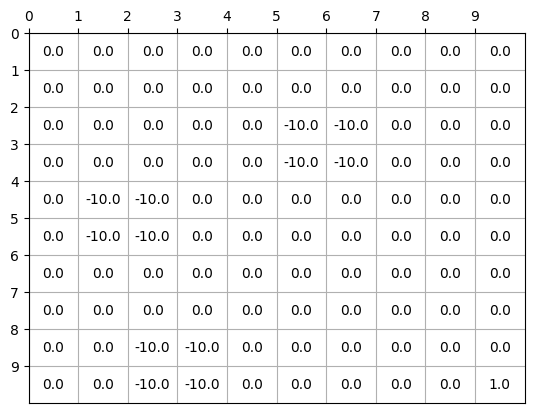

In [ ]:
def reward_grid_plot(rw_function=1):
    reward_matrix = np.zeros((grid_size, grid_size))
    for j in range(grid_size):
        for i in range(grid_size):
            reward_matrix[i][j] = gw.reward(gw.point_to_int((i,j)), rw_function)
    plot_matrix(reward_matrix)
    return reward_matrix
reward_matrix = reward_grid_plot(rw_function=1)

In [ ]:
def plot_heatmap(grid, title):
    plt.pcolor(grid, edgecolors="black")
    for i in range(grid.shape[0]):
      for j in range(grid.shape[1]):
        plt.text(0.5+j, 0.5+i, f'{reward_matrix[i, j]:.0f}', 
                 ha='center', va='center', color='w')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(title)
    plt.show()
    # plt.axis('off')

In [ ]:
## Function for plotting the optimal actions at each state in the grid
## The function takes as input the matrix containing optimal actions
## and plots the actions for each state on the grid

def plot_arrow(action_matrix):
    
    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'↓'
            elif(c == 1):
                arrow = u'→'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'←'
            
            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()

**Question 11:**

  0%|          | 0/500 [00:00<?, ?it/s]

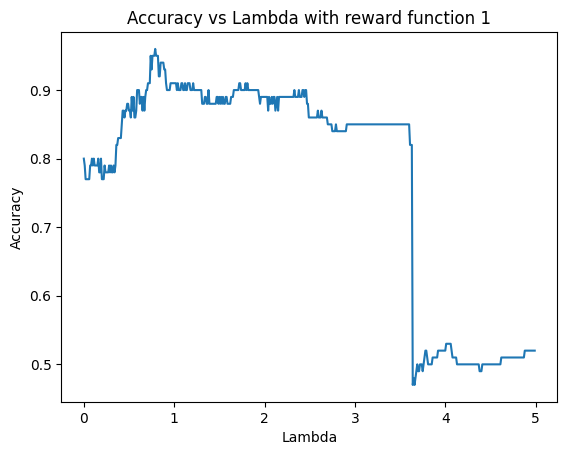

In [ ]:
w = 0.1
gamma = 0.8
epsilon = 0.01
optimal_policy = get_optimal_policy(w, gamma, reward_func1, epsilon)
optimal_policy = optimal_policy.T.flatten()

lambdas = np.arange(0, 5.00, 0.01)
r_max = abs(reward_func1).max()
title = "Accuracy vs Lambda with reward function 1"
accs = plot_and_get_accuracies(lambdas, optimal_policy, gamma, r_max, title)

**Question 12:**

In [ ]:
lambda_max1 = lambdas[np.argmax(accs)]
print("Max accuracy:", max(accs))
print("λ(1)max:", lambda_max1)

Max accuracy: 0.96
λ(1)max: 0.79


**Question 13:**

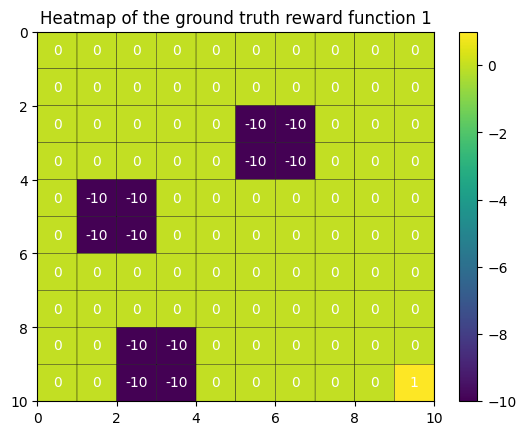

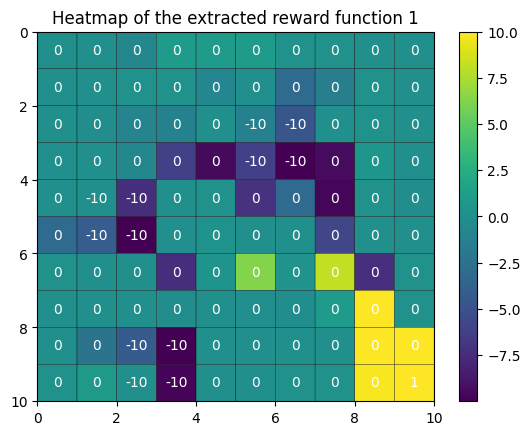

In [ ]:
D, b = calculate_D_and_b(optimal_policy, gamma, r_max)
c = calculate_c(lambda_max1)
rewards = get_lp_rewards(c, D, b)
rewards = rewards.reshape(10,10).T
plot_heatmap(reward_func1, "Heatmap of the ground truth reward function 1")
plot_heatmap(rewards, "Heatmap of the extracted reward function 1")

Number of steps to converge: 31


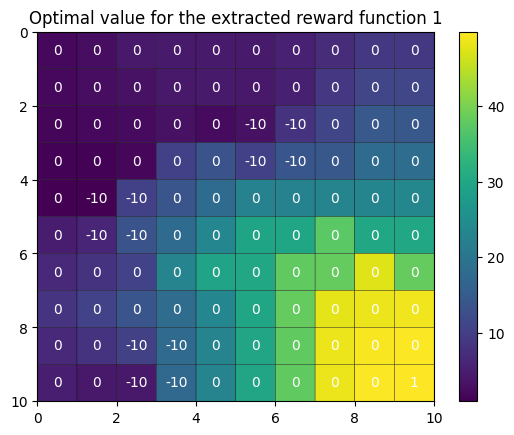

In [ ]:
snapshots = compute_state_value_snapshots(w, gamma, rewards, epsilon)
plot_heatmap(snapshots[-1], "Optimal value for the extracted reward function 1")

In [ ]:
optimal_policy = find_policy(w, gamma, rewards, epsilon)

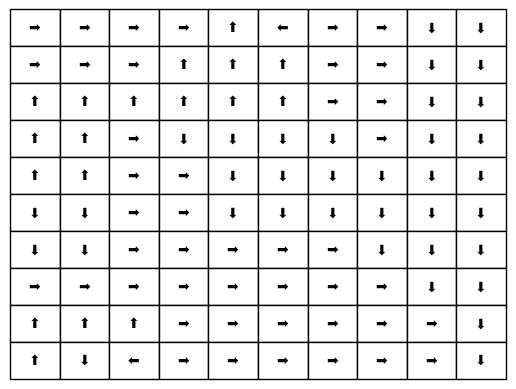

In [ ]:
# Given array
arr = optimal_policy

# Mapping of arrow characters to custom arrow Unicode characters
arrow_map = {
    '↑': '⬆️',
    '→': '➡️',
    '↓': '⬇️',
    '←': '⬅️'
}

# Convert arrow characters to custom arrow Unicode characters
arr_custom = np.vectorize(arrow_map.get)(arr)

# Create a figure and axes
fig, ax = plt.subplots()

# Hide axes
ax.axis('off')

# Create a table to display the arrows
table = ax.table(cellText=arr_custom, cellLoc='center', bbox=[0, 0, 1, 1])

# Set font properties
fontprops = {'fontsize': 100, 'verticalalignment': 'center'}

# Show the plot
plt.show()

  0%|          | 0/501 [00:00<?, ?it/s]

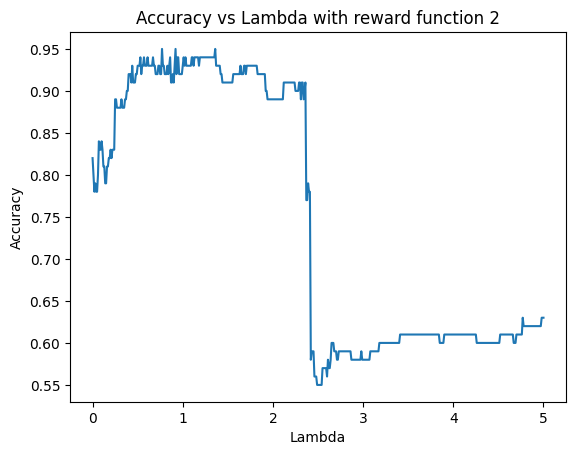

In [ ]:
best_policy = find_policy(w, gamma, reward_func2, epsilon)
best_policy = best_policy.transpose().ravel()

maximum_reward = abs(reward_func2).max()
graph_title = "Accuracy vs Lambda with reward function 2"
accuracy_values = plot_and_get_accuracies(lambdas, best_policy, gamma, maximum_reward, graph_title)